# Imports

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
from keras.utils import np_utils
import GPyOpt
from sklearn.model_selection import ParameterSampler

2023-02-19 16:43:59.987617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X[1].shape)
#plt.imshow(train_X[1], cmap = "Greys")
#plt.show()

# one-out-of-k encoding of the labels
# using keras' numpy-related utilities
n_classes = 10
print("Shape (train) before one-hot encoding: ", train_y.shape)
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print("Shape (train) after one-hot encoding: ", Y_train.shape)

(28, 28)
Shape (train) before one-hot encoding:  (60000,)
Shape (train) after one-hot encoding:  (60000, 10)


# CNN Model

In [3]:
CNN = ks.models.Sequential()
# convolutional layer
CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
# flatten output of conv
CNN.add(ks.layers.Flatten())
# hidden layer
CNN.add(ks.layers.Dense(100, activation='relu'))
# output layer
CNN.add(ks.layers.Dense(10, activation='softmax'))

CNN.summary()

CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

CNN.fit(train_X, Y_train, batch_size = 32)

acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
print(acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 25)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4225)              0         
                                                                 
 dense (Dense)               (None, 100)               422600    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 423,860
Trainable params: 423,860
Non-trainable params: 0
__________________________________________________

2023-02-19 16:44:06.239406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9686
0.9685999751091003


# Bayesian Optimization

In [7]:
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)
batch_size = tuple(np.arange(1,101,1, dtype= np.int)) # batch_size (1-100)

# define the dictionary for GPyOpt
domain = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
    {"name": "batch_size", "type": "discrete", "domain": batch_size},
]

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(int(param[0]), activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = int(param[1]))
    acc = CNN.evaluate(test_X, Y_test, batch_size = int(param[1]))[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_nodes=" + str(x_best[0]) + ", batch_size=" + str(x_best[1]))
print(opt.Y.shape)

228/228 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9678
0.9678000211715698
197/197 [==============================] - 1s 2ms/step - loss: 0.4568 - accuracy: 0.8966
0.8966000080108643
193/193 [==============================] - 1s 3ms/step - loss: 0.1250 - accuracy: 0.9641
0.9641000032424927
589/589 [==============================] - 1s 1ms/step - loss: 0.1169 - accuracy: 0.9657
0.9656999707221985
313/313 [==============================] - 1s 2ms/step - loss: 0.1371 - accuracy: 0.9661
0.9660999774932861
228/228 [==============================] - 1s 2ms/step - loss: 0.1566 - accuracy: 0.9600
0.9599999785423279
295/295 [==============================] - 1s 2ms/step - loss: 0.1211 - accuracy: 0.9644
0.9643999934196472
100/100 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9593
0.9592999815940857
10000/10000 [==============================] - 6s 599us/step - loss: 0.2233 - accuracy: 0.9522
0.9521999955177307
264/264 [=============

# Random Search

In [11]:
import time 

# hyperparams dictionary 

domain = {"n_nodes": n_nodes,
        "batch_size": batch_size}

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)
#rounded_list = [dict((k,v) for (k, v) in d.items()) for d in param_list]

#print('Random parameters we are going to consider')
#print(rounded_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_acc = 0
iteration_best_acc = 0 
max_acc_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(100, activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    CNN.fit(train_X, Y_train, batch_size = 32)
    end = time.time()
    acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
    print('Accuracy found:', acc)
    if acc > current_best_acc:
        current_best_acc = acc
        iteration_best_acc = i
    
    max_acc_per_iteration.append(current_best_acc)
    i += 1
    print(f'It took {end - start} seconds')
    

Param list
[{'n_nodes': 72, 'batch_size': 98}, {'n_nodes': 27, 'batch_size': 96}, {'n_nodes': 31, 'batch_size': 41}, {'n_nodes': 72, 'batch_size': 76}, {'n_nodes': 45, 'batch_size': 85}, {'n_nodes': 44, 'batch_size': 32}, {'n_nodes': 7, 'batch_size': 47}, {'n_nodes': 46, 'batch_size': 68}, {'n_nodes': 44, 'batch_size': 39}, {'n_nodes': 51, 'batch_size': 95}, {'n_nodes': 2, 'batch_size': 83}, {'n_nodes': 25, 'batch_size': 52}, {'n_nodes': 20, 'batch_size': 79}, {'n_nodes': 76, 'batch_size': 95}, {'n_nodes': 43, 'batch_size': 15}, {'n_nodes': 28, 'batch_size': 83}, {'n_nodes': 71, 'batch_size': 98}, {'n_nodes': 43, 'batch_size': 89}, {'n_nodes': 5, 'batch_size': 21}, {'n_nodes': 7, 'batch_size': 36}]
0
{'n_nodes': 72, 'batch_size': 98}
313/313 [==============================] - 1s 2ms/step - loss: 0.1125 - accuracy: 0.9672
Accuracy found: 0.967199981212616
It took 10.155843019485474 seconds
1
{'n_nodes': 27, 'batch_size': 96}
313/313 [==============================] - 1s 2ms/step - loss:

# Comparison

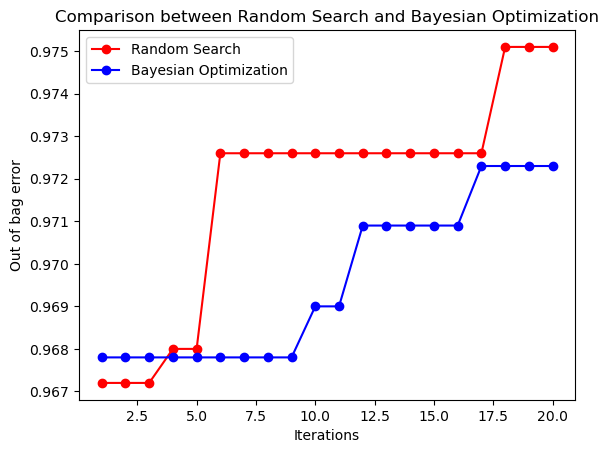

In [12]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO, note that it is also provided by GPOpt in Y_Best
y_bo = np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)
xp = np.arange(1,y_bo.shape[0] + 1,1)

plt.plot(xs, max_acc_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xp, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Out of bag error')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

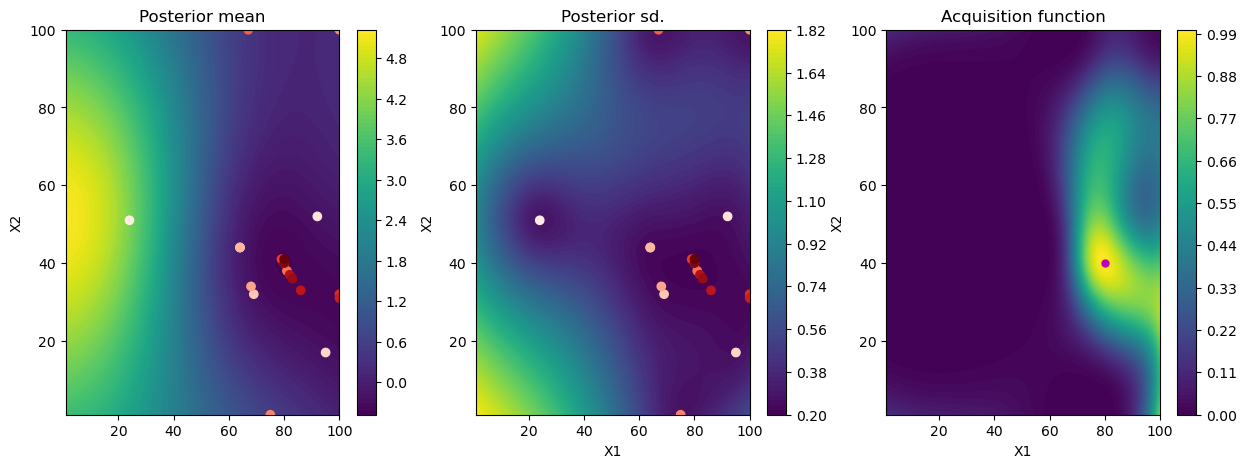

In [14]:
opt.plot_acquisition() #Virker først med 2D

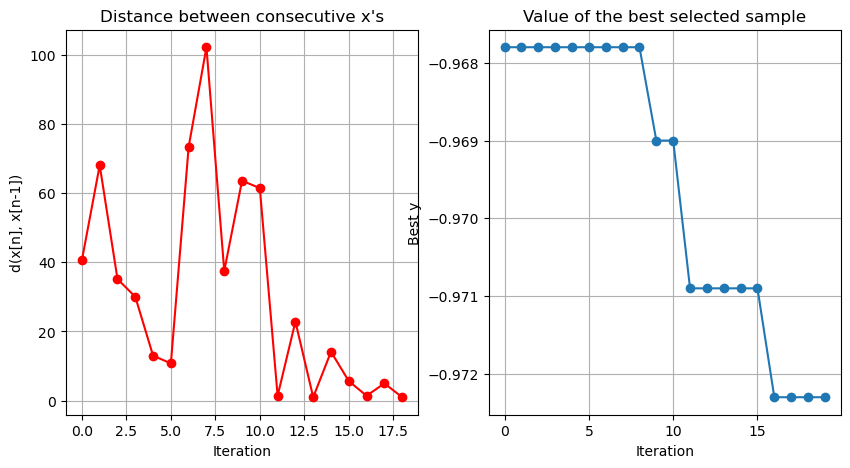

'We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample.'

In [15]:
opt.plot_convergence() #Convergence
"""We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample."""